In [17]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt


In [18]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = "garbage_dataset"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.30  # 15% val + 15% test
)

# Training Data
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valtest_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class labels:", class_names)


Found 10865 images belonging to 12 classes.
Found 4650 images belonging to 12 classes.
Class labels: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [19]:
valtest_images, valtest_labels = next(valtest_generator)
for _ in range((valtest_generator.samples // BATCH_SIZE) - 1):
    imgs, lbls = next(valtest_generator)
    valtest_images = tf.concat([valtest_images, imgs], axis=0)
    valtest_labels = tf.concat([valtest_labels, lbls], axis=0)

val_size = len(valtest_images) // 2
x_val = valtest_images[:val_size]
y_val = valtest_labels[:val_size]

x_test = valtest_images[val_size:]
y_test = valtest_labels[val_size:]



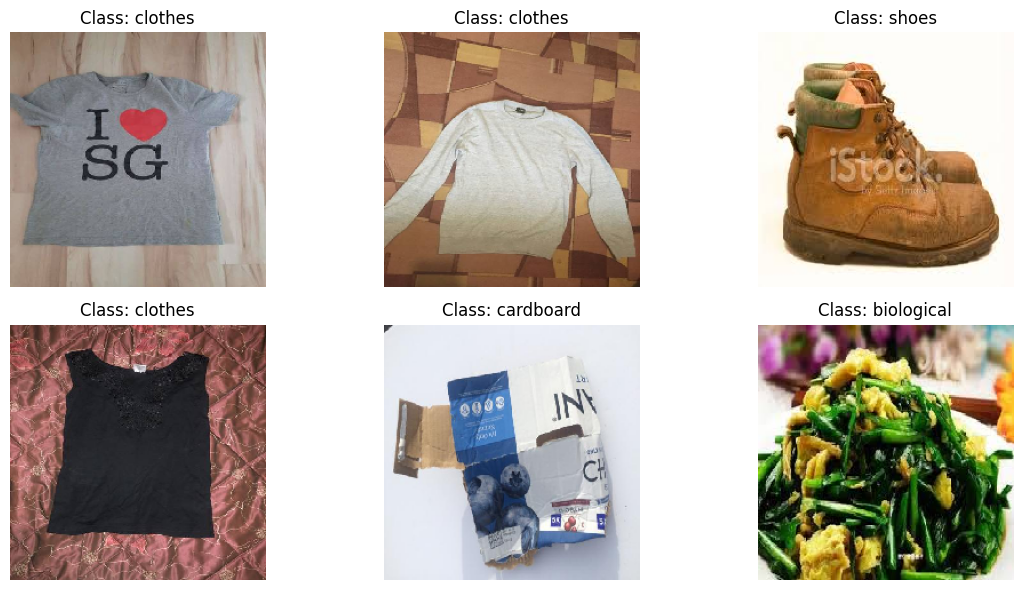

In [20]:

plt.figure(figsize=(12, 6))
for i in range(6):
    img, label = next(train_generator)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Class: {class_names[label[0].argmax()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [44]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
import keras

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [45]:
EPOCHS = 10
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=(x_val, y_val)
)


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 263s 761ms/step - accuracy: 0.3389 - loss: 2.1467 - val_accuracy: 0.7138 - val_loss: 0.9749
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 274s 806ms/step - accuracy: 0.7365 - loss: 0.9226 - val_accuracy: 0.8056 - val_loss: 0.6602
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 222s 652ms/step - accuracy: 0.8311 - loss: 0.6211 - val_accuracy: 0.8371 - val_loss: 0.5319
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 1187s 3s/step - accuracy: 0.8578 - loss: 0.5015 - val_accuracy: 0.8586 - val_loss: 0.4620
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 13487s 40s/step - accuracy: 0.8767 - loss: 0.4305 - val_accuracy: 0.8655 - val_loss: 0.4247
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 197s 578ms/step - accuracy: 0.8908 - loss: 0.3833 - val_accuracy: 0.8806 - val_loss: 0.3922
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 157s 462ms/step - accuracy: 0.9046 - loss: 0.3369 - val_accuracy: 0.8828 - val_loss: 0.3719
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 224s 659ms/step - accuracy: 0.9055 - l

In [ ]:
model.save("model/garbage_classifier_model.keras")


In [37]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"🧪 Test Accuracy: {test_accuracy:.2%}")
print(f"📉 Test Loss: {test_loss:.4f}")


73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 541ms/step - accuracy: 0.8745 - loss: 0.3848
🧪 Test Accuracy: 88.49%
📉 Test Loss: 0.3607


In [40]:
from tensorflow.keras.preprocessing import image
import numpy as np

class_to_bin = {
    "plastic": "Recyclable",
    "metal": "Recyclable",
    "paper": "Recyclable",
    "cardboard": "Recyclable",
    "white-glass": "Recyclable",
    "green-glass": "Recyclable",
    "brown-glass": "Recyclable",
    "biological": "Organic",
    "trash": "General Waste",
    "clothes": "General Waste",
    "shoes": "General Waste",
    "batteries": "General Waste"  
}

def predict_bin(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    pred_class = class_names[pred_index]
    confidence = np.max(preds)
    bin_type = class_to_bin.get(pred_class, "Unknown")

    return pred_class, bin_type, confidence


In [42]:
img_path = "test_images/img_4.jpeg" 

pred_class, bin_type, confidence = predict_bin(img_path)

print(f"🧠 Predicted Class: {pred_class}")
print(f"🗑️ Assigned Bin: {bin_type}")
print(f"🎯 Confidence: {confidence:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
🧠 Predicted Class: clothes
🗑️ Assigned Bin: General Waste
🎯 Confidence: 87.91%
